In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
import re

In [2]:
data = pd.read_csv('IMDBe2.csv')
# Keeping only the neccessary columns
data = data[['review','sentiment']]

In [3]:
data = data[data.sentiment != "Neutral"]
data['review'] = data['review'].apply(lambda x: x.lower()) #Converts to lower case
data['review'] = data['review'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x))) # Replaces any non alpha-numeric data with empty string

print(data[ data['sentiment'] == 'positive'].size)
print(data[ data['sentiment'] == 'negative'].size)

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ') 
    
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ') 
tokenizer.fit_on_texts(data['review'].values) # breaking down text to individual tokens
X = tokenizer.texts_to_sequences(data['review'].values) #converts each string to a sequence of integer tokens
X = pad_sequences(X) # ensures that all the sequences are of same length

2000
2000


<AxesSubplot: xlabel='sentiment', ylabel='count'>

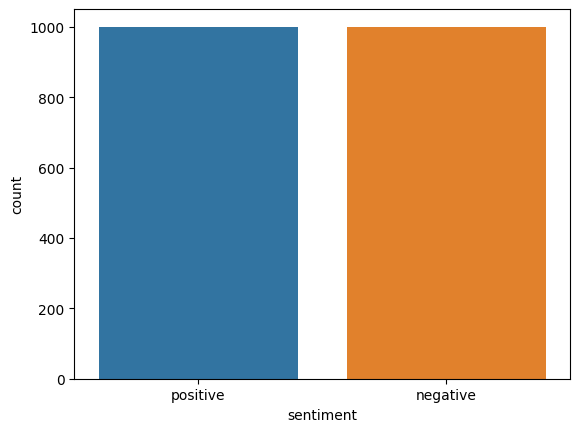

In [4]:
import seaborn as sns

sns.countplot(x = data['sentiment'])

In [5]:
embed_dim = 48 # hyper parameters
lstm_out = 64 # no of output units

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1])) #adding embedding layer
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)) #drop out rates to prevent overfitting
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1324, 48)          96000     
                                                                 
 spatial_dropout1d (SpatialD  (None, 1324, 48)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                28928     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 125,058
Trainable params: 125,058
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1700, 1324) (1700, 2)
(300, 1324) (300, 2)


In [7]:
batch_size = 32
history = model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, verbose = 1)

Epoch 1/10
54/54 [==============================] - 68s 1s/step - loss: 0.6925 - accuracy: 0.5118
Epoch 2/10
54/54 [==============================] - 64s 1s/step - loss: 0.6567 - accuracy: 0.7182
Epoch 3/10
54/54 [==============================] - 63s 1s/step - loss: 0.5379 - accuracy: 0.7718
Epoch 4/10
54/54 [==============================] - 63s 1s/step - loss: 0.3847 - accuracy: 0.8312
Epoch 5/10
54/54 [==============================] - 63s 1s/step - loss: 0.2566 - accuracy: 0.8976
Epoch 6/10
54/54 [==============================] - 65s 1s/step - loss: 0.1987 - accuracy: 0.9253
Epoch 7/10
54/54 [==============================] - 64s 1s/step - loss: 0.1589 - accuracy: 0.9447
Epoch 8/10
54/54 [==============================] - 65s 1s/step - loss: 0.2179 - accuracy: 0.9124
Epoch 9/10
54/54 [==============================] - 64s 1s/step - loss: 0.1044 - accuracy: 0.9706
Epoch 10/10
54/54 [==============================] - 64s 1s/step - loss: 0.0838 - accuracy: 0.9718


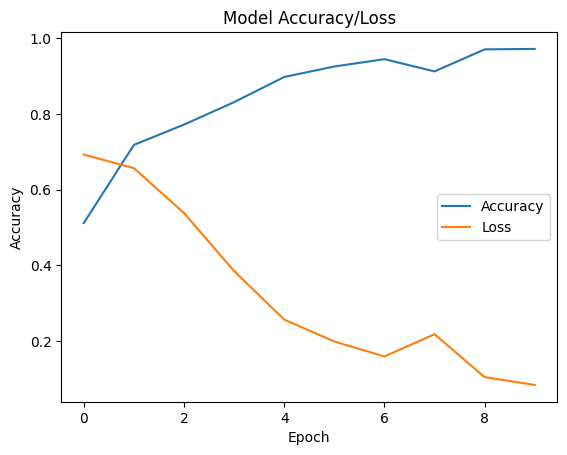

In [8]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy','Loss'], loc = 'center right')
plt.show()

In [9]:
validation_size = 75
batch_size = 32
X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))

8/8 - 2s - loss: 0.5484 - accuracy: 0.8178 - 2s/epoch - 189ms/step
Score: 0.55
Validation Accuracy: 0.82


In [10]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

1/1 - 0s - 460ms/epoch - 460ms/step
1/1 - 0s - 103ms/epoch - 103ms/step
1/1 - 0s - 100ms/epoch - 100ms/step
1/1 - 0s - 104ms/epoch - 104ms/step
1/1 - 0s - 101ms/epoch - 101ms/step
1/1 - 0s - 102ms/epoch - 102ms/step
1/1 - 0s - 109ms/epoch - 109ms/step
1/1 - 0s - 101ms/epoch - 101ms/step
1/1 - 0s - 105ms/epoch - 105ms/step
1/1 - 0s - 102ms/epoch - 102ms/step
1/1 - 0s - 107ms/epoch - 107ms/step
1/1 - 0s - 101ms/epoch - 101ms/step
1/1 - 0s - 107ms/epoch - 107ms/step
1/1 - 0s - 107ms/epoch - 107ms/step
1/1 - 0s - 109ms/epoch - 109ms/step
1/1 - 0s - 107ms/epoch - 107ms/step
1/1 - 0s - 104ms/epoch - 104ms/step
1/1 - 0s - 105ms/epoch - 105ms/step
1/1 - 0s - 100ms/epoch - 100ms/step
1/1 - 0s - 100ms/epoch - 100ms/step
1/1 - 0s - 101ms/epoch - 101ms/step
1/1 - 0s - 104ms/epoch - 104ms/step
1/1 - 0s - 102ms/epoch - 102ms/step
1/1 - 0s - 109ms/epoch - 109ms/step
1/1 - 0s - 101ms/epoch - 101ms/step
1/1 - 0s - 102ms/epoch - 102ms/step
1/1 - 0s - 101ms/epoch - 101ms/step
1/1 - 0s - 101ms/epoch - 101

In [11]:
Y_pred = model.predict(X_validate)

# convert predicted probabilities to class labels
Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_validate, axis=1)

# calculate classification report and confusion matrix
print("Classification Report:\n", classification_report(Y_true, Y_pred))
print("Confusion Matrix:\n", confusion_matrix(Y_true, Y_pred))

# calculate mean squared error, mean absolute error, and root mean squared error
mse = mean_squared_error(Y_true, Y_pred)
mae = mean_absolute_error(Y_true, Y_pred)
rmse = np.sqrt(mse)

print("Mean Squared Error: %.8f" % mse)
print("Mean Absolute Error: %.8f" % mae)
print("Root Mean Squared Error: %.8f" % rmse)

3/3 [==============================] - 1s 134ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.75      0.81        40
           1       0.76      0.89      0.82        35

    accuracy                           0.81        75
   macro avg       0.82      0.82      0.81        75
weighted avg       0.82      0.81      0.81        75

Confusion Matrix:
 [[30 10]
 [ 4 31]]
Mean Squared Error: 0.18666667
Mean Absolute Error: 0.18666667
Root Mean Squared Error: 0.43204938


In [11]:
# Validating the model using an arbitrary sentence


twt = ['the movie is pretty bad and boring.']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=32,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   1  17   6 180  81   3 383]]
1/1 - 0s - 161ms/epoch - 161ms/step
negative


In [ ]:
from sklearn,metrics import plot_confusion_matrix


In [12]:
#Validating the model using an arbitrary sentence

twt = ['The team really did a great job. Very good movie']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=32,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    1 697  62 118   2  86 359  50  49  17]]
1/1 - 0s - 15ms/epoch - 15ms/step
positive


In [4]:
# Mean accuracy with Standard deviation
import scipy.stats as stats
import numpy as np

LSTM_acc = [0.9600,0.9582,0.9576,0.9521,0.9456]

mean_acc = np.mean(LSTM_acc)
std_error = stats.sem(LSTM_acc)

print('Mean accuracy: {:.4f} +/- {:.4f}'.format(mean_acc,std_error))

Mean accuracy: 0.9547 +/- 0.0026
